In [ ]:
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn import datasets, metrics, model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from tensorflow import keras

import os
import tempfile
import networkx as nx
import matplotlib as mpl
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# I can use in my model the best results that I have from NN for CC 3 layers 
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model



def get_new_train_data(predictions, fold_n):
    X_new = list()
    y_new = list()
    
    for i, prediction in enumerate(predictions):
        if prediction > 0.95 or prediction < 0.05:
            X_new.append(X_fold[fold_n][i])
            y_new.append(np.argmax(prediction))
    
    return np.array(X_new), np.array(y_new)

def join_shuffle(X_train, y_train, X_new, y_new):
    X_train = np.vstack((X_train, X_new))
    y_train = np.append(y_train, y_new)
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    return X_train[indices], y_train[indices]

In [ ]:
sns.set(style="whitegrid")
np.random.seed(203)

In [ ]:
#file = tf.keras.utils
raw_features=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_features.csv")
raw_classes=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_classes.csv")
raw_edgelist=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_edgelist.csv")

In [ ]:
raw_classes['class'].value_counts()

unknown    157205
2           42019
1            4545
Name: class, dtype: int64

In [ ]:
# renaming columns
raw_features.columns = ['id', 'time'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,...,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.077909,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.1

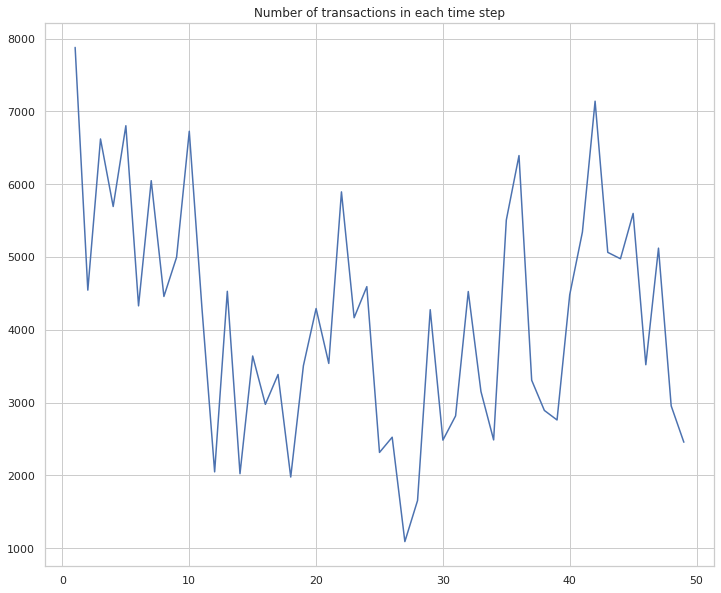

In [ ]:
raw_features['time'].value_counts().sort_index().plot();
plt.title('Number of transactions in each time step');

In [ ]:
# merge with classes
raw_features = pd.merge(raw_features, raw_classes, left_on='id', right_on='txId', how='left')

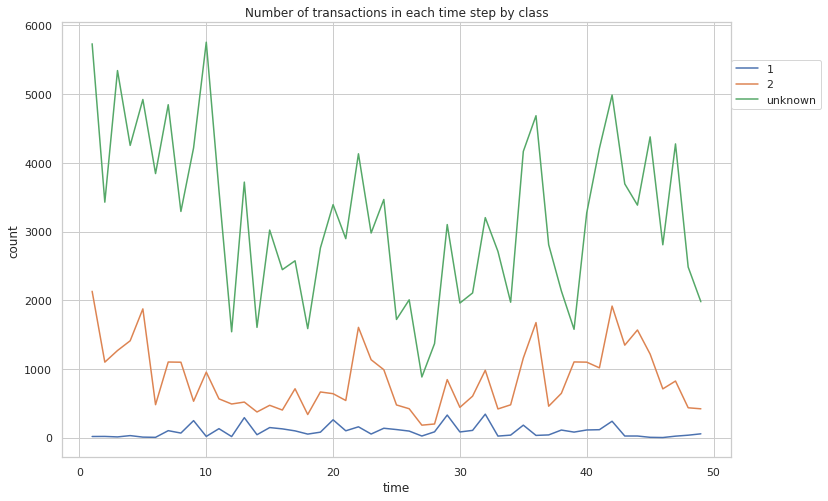

In [ ]:
plt.figure(figsize=(12, 8))
grouped = raw_features.groupby(['time', 'class'])['id'].count().reset_index().rename(columns={'id': 'count'})
sns.lineplot(x='time', y='count', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by class');

In [ ]:
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,...,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,txId,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,unknown
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,unknown
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.169472,-0.470592,-0.511871,-0.400422,

In [ ]:
raw_features=raw_features.rename(columns={"class":"Class"})

In [ ]:
cleaned_df = raw_features.copy()
# You don't want the `Time` column.
cleaned_df.pop('time')
# You don't want the `txId` column.
cleaned_df.pop('txId')
# You don't want the `id` column.
cleaned_df.pop('id')

0           5530458
1         232022460
2         232438397
3         230460314
4         230459870
            ...    
203763    173077460
203764    158577750
203765    158375402
203766    158654197
203767    157597225
Name: id, Length: 203768, dtype: int64

In [ ]:
# Using "-1" to fill out unknown Class
cleaned_df['Class'].replace({"unknown": "-1"}, inplace=True)
cleaned_df['Class'].replace({"1": "1"}, inplace=True)
cleaned_df['Class'].replace({"2": "0"}, inplace=True)
cleaned_df['Class'] = pd.to_numeric(cleaned_df['Class'])

In [ ]:
#df["new_column"] = np.random.choice([1, 0], len(df), p=[0.7, 0.3])   #  0) First step
def rand_bin_array(K, N):
    arr = np.zeros(N,int)

    arr[:K]  = int( 1)
    np.random.shuffle(arr)
    return arr

In [ ]:
prueba_0=cleaned_df[cleaned_df['Class']==0] # 1) Split 0 array 
prueba_0

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,0.026315,-0.227215,...,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
8,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,-0.163135,1.696691,2.414968,-0.063200,-0.013282,2.370512,0.001525,-0.172908,0.221419,-0.243300,-0.243452,-0.139732,-0.147416,-0.079747,-0.155559,0.665165,1.037078,-0.139734,-0.147411,-0.079746,-0.155559,0.665251,1.037113,-0.024669,-0.031272,-0.023045,-0.026215,-0.973502,-0.973372,-0.227159,...,-0.124629,0.525309,0.617474,0.317264,-0.121020,-0.188716,-0.032710,-0.047722,-0.048171,-1.373902,-1.356289,-0.301754,-1.404621,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
9,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,-0.140266,-0.028741,-0.035391,-0.042955,-0.013282,-0.006754,-0.148916,-0.151494,-0.146513,0.887058,0.884557,-0.139721,-0.148905,-0.080147,-0.155653,-0.010763,-0.012107,-0.139723,-0.148901,-0.080147,-0.155653,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.115680,-0.190199,-0.177836,-0.201578,1.064205,1.063787,-1.373932,-1.356183,-0.301411,-1.404577,-0.975738,-0.975237,-0.168742,-0.445357,-0.409015,-0.427594,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
10,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,-0.143847,-0.028741,-0.035391,-0.042955,-0.013282,-0.038424,-0.150266,-0.150457,-0.150661,0.887058,0.884557,-0.139722,-0.148906,-0.080147,-0.155654,-0.010763,-0.012107,-0.139724,-0.148902,-0.080147,-0.155654,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.107516,-0.190820,-0.180486,-0.200607,1.064205,1.063787,-1.373902,-1.348835,-0.282308,-1.400475,-0.975738,-0.975237,-0.168742,-0.454961,-0.420758,-0.436915,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997

In [ ]:
prueba_1=cleaned_df[cleaned_df['Class']==1] # 1) Split 0 array 
prueba_1

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
906,-0.172669,0.048298,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.163319,-0.169138,-0.049707,-0.165623,-0.028741,-0.035391,-0.042955,-0.013282,-0.056486,-0.170893,-0.172687,-0.175893,-1.373657,-1.371460,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227178,...,-0.121362,0.003143,0.002426,0.034682,-0.171766,-0.188716,-0.149358,-0.047722,-0.048171,-1.373812,-1.356210,-0.301754,-1.404533,0.183133,0.182748,0.060963,-0.386969,-0.424672,-0.301819,0.143001,0.142525,0.660117,-0.375715,-1.059868,0.142339,0.185597,0.185492,0.398638,-0.458316,-0.577099,-0.285627,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
1360,-0.164417,0.048298,-1.201369,0.178180,-0.043875,0.222447,-0.061584,-0.163580,-0.164278,-0.022718,-0.164197,-1.353307,-0.770605,-0.042955,-0.013282,-0.056489,-0.162409,-0.162936,-0.166124,-1.373657,-1.371460,-0.139732,-0.148893,-0.080129,-0.155652,-1.191904,-0.815353,-0.139734,-0.148891,-0.080130,-0.155653,-1.272639,-0.815199,-0.024669,-0.026775,-0.007652,-0.025190,-0.476835,-3.127893,-0.227215,...,-0.120955,1.844668,0.797411,-0.091535,-0.103042,-0.072684,-0.096422,-1.159649,-1.160129,-1.373812,-1.264494,-0.062493,-1.353515,1.342003,1.340733,-0.126628,-0.429352,-0.405404,-0.399390,1.301966,1.301281,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.193143,-0.513559,-0.457532,-0.500080,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,1
2717,-0.164272,0.048298,-1.201369,0.028105,-0.043875,0.054722,-0.061584,-0.163191,-0.163923,-0.016812,-0.162980,2.457052,2.415325,-0.042955,-0.013282,-0.056489,-0.162260,-0.162765,-0.165952,-1.373657,-1.371460,-0.139726,-0.148898,-0.080137,-0.155649,1.066243,1.326635,-0.139727,-0.148893,-0.080136,-0.155649,1.066325,1.326651,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227168,...,-0.124751,0.003143,0.002426,-0.065979,-0.103042,-0.078511,-0.091148,-1.159649,-1.160129,-1.373812,-1.349888,-0.285263,-1.401017,1.342003,1.340733,-0.126628,1.240965,1.637005,1.221865,1.301966,1.301281,1.203124,0.146997,-1.059868,0.749451,0.185597,0.185492,0.185597,1.585683,1.978649,1.757982,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
2814,-0.168195,0.048298,-1.201369,-0.046932,-0.063725,-0.029140,-0.061584,-0.163574,-0.164695,-0.006824,-0.163500,2.459222,2.415325,-0.063200,-0.013282,0.011805,-0.166228,-0.172908,-0.164929,-0.243300,-0.243452,-0.139721,-0.148898,-0.080137,-0.155648,-2.700912,-2.689592,-0.139723,-0.148894,-0.080136,-0.155648,-2.700785,-2.689318,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227149,...,-0.129496,0.003143,0.002426,-0.085726,-0.193389,-0.188716,-0.199062,-0.047722,-0.048171,-1.373753,-1.356157,-0.301754,-1.404475,0.183133,0.182748,-0.161512,-0.455921,-0.424672,-0.435673,0.143001,0.142525,-0.425896,-1.421138,-1.0

In [ ]:
prueba=cleaned_df[cleaned_df['Class']==-1]  # 2) Split array -1
prueba

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227178,...,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,-1
3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.169472,-0.470592,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,-1
4,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,0.038305,0.816377,-0.108000,0.907577,0.517402,0.341693,-0.013282,-0.057392,0.060033,-0.010829,-0.048401,-0.243639,-0.534976,-0.139732,-0.148855,-0.080110,-0.155641,1.001646,0.591836,-0.139734,-0.148851,-0.080109,-0.155641,1.001728,0.591900,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.088827,0.003143,0.002426,-0.101046,0.704558,0.382060,0.272503,-0.433005,-0.492387,-1.373962,-1.354445,-0.300062,-1.404412,-0.108018,-0.357362,-0.168742,-0.441465,-0.415693,-0.419836,-0.330396,-0.236199,-0.968903,-0.375715,-0.498323,-1.592267

In [ ]:
prueba['Class']=rand_bin_array(15720,157204)  # 3) Change array -1  target with a relation 1/10  Illicit-Licit

In [ ]:
#Full Dataset
vertical = pd.concat([prueba, prueba_0,prueba_1], axis=0) #4) Put together all changes

In [ ]:
vertical=vertical.sort_index()   # 5) Order again new field
vertical.reindex

<bound method DataFrame.reindex of         trans_feat_0  trans_feat_1  ...  agg_feat_71  Class
0          -0.171484     -0.184668  ...    -0.119792      1
1          -0.172107     -0.184668  ...    -0.119792      0
2           0.163054      1.963790  ...    -0.119792      0
3           1.011523     -0.081127  ...     0.179117      0
4           0.961040     -0.081127  ...    -0.695540      0
...              ...           ...  ...          ...    ...
203763     -0.145771     -0.163752  ...    -0.119792      0
203764     -0.165920     -0.123607  ...    -1.760984      0
203765     -0.172014     -0.078182  ...    -0.119792      1
203766     -0.172842     -0.176622  ...     1.521399      0
203767     -0.012037     -0.132276  ...     1.521399      0

[203768 rows x 166 columns]>

In [ ]:
data= vertical.copy()
y=vertical['Class']

In [ ]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(vertical, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

test_df_class=test_df.copy()

# Form np arrays of labels and features.
#labels are output
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

#features are inputs from split
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

#Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

#Note: The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (130411,)
Validation labels shape: (32603,)
Test labels shape: (40754,)
Training features shape: (130411, 165)
Validation features shape: (32603, 165)
Test features shape: (40754, 165)


In [ ]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,183503,90.05
1,1,20265,9.95


In [ ]:
# I can take my model from the best CC 3 layers
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model



def get_new_train_data(predictions, fold_n):
    X_new = list()
    y_new = list()
    
    for i, prediction in enumerate(predictions):
        if prediction > 0.95 or prediction < 0.05:
            X_new.append(X_fold[fold_n][i])
            y_new.append(np.argmax(prediction))
    
    return np.array(X_new), np.array(y_new)

def join_shuffle(X_train, y_train, X_new, y_new):
    X_train = np.vstack((X_train, X_new))
    y_train = np.append(y_train, y_new)
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    return X_train[indices], y_train[indices]

In [ ]:
X_pad=train_features
y_train_m= train_labels

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

X_fold = list()
y_fold = list()

for _, fold in kf.split(X_pad):
    
    X_fold.append(X_pad[fold])
    y_fold.append(y_train_m[fold])
    
X_fold = np.array(X_fold)
y_fold = np.array(y_fold)

In [ ]:
# The 0th fold will be our known labeled, the rest folds are assumed to be unlabeled
X_train = X_fold[0]
y_train = y_fold[0]

model = make_model()
model.fit(X_train[:-10000], y_train[:-10000], epochs=10, 
          validation_data=(X_train[-10000:], y_train[-10000:]))        

Epoch 1/10
503/503 [==============================] - 7s 8ms/step - loss: 0.3172 - tp: 0.0000e+00 - fp: 7.0000 - tn: 14519.0000 - fn: 1557.0000 - accuracy: 0.9028 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6196 - prc: 0.1760 - val_loss: 0.3161 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8989.0000 - val_fn: 1011.0000 - val_accuracy: 0.8989 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6252 - val_prc: 0.2115
Epoch 2/10
503/503 [==============================] - 3s 7ms/step - loss: 0.3051 - tp: 13.0000 - fp: 6.0000 - tn: 14520.0000 - fn: 1544.0000 - accuracy: 0.9036 - precision: 0.6842 - recall: 0.0083 - auc: 0.6451 - prc: 0.2165 - val_loss: 0.3144 - val_tp: 16.0000 - val_fp: 10.0000 - val_tn: 8979.0000 - val_fn: 995.0000 - val_accuracy: 0.8995 - val_precision: 0.6154 - val_recall: 0.0158 - val_auc: 0.6346 - val_prc: 0.2253
Epoch 3/10
503/503 [==============================] - 3s 7ms/step - loss: 0.2968 - tp: 54.0000 - fp: 44.0000 - tn: 14482.0000 - 

In [ ]:
predictions = model.predict(X_fold[1])
X_new, y_new = get_new_train_data(predictions, 1)
X_train, y_train = join_shuffle(X_train, y_train, X_new, y_new)

model = make_model()
model.fit(X_train[:-10000], y_train[:-10000], epochs=2,
          validation_data=(X_train[-10000:], y_train[-10000:]))

Epoch 1/2
771/771 [==============================] - 7s 7ms/step - loss: 0.2589 - tp: 121.0000 - fp: 114.0000 - tn: 31664.0000 - fn: 2763.0000 - accuracy: 0.9170 - precision: 0.5149 - recall: 0.0420 - auc: 0.6711 - prc: 0.2001 - val_loss: 0.2331 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 9305.0000 - val_fn: 695.0000 - val_accuracy: 0.9305 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7024 - val_prc: 0.1932
Epoch 2/2
771/771 [==============================] - 5s 6ms/step - loss: 0.2468 - tp: 43.0000 - fp: 27.0000 - tn: 22762.0000 - fn: 1830.0000 - accuracy: 0.9247 - precision: 0.6143 - recall: 0.0230 - auc: 0.7074 - prc: 0.2213 - val_loss: 0.2314 - val_tp: 55.0000 - val_fp: 43.0000 - val_tn: 9262.0000 - val_fn: 640.0000 - val_accuracy: 0.9317 - val_precision: 0.5612 - val_recall: 0.0791 - val_auc: 0.6935 - val_prc: 0.2139


In [ ]:
# Predict samples in fold 2
predictions = model.predict(X_fold[2])

# Filter out samples in fold 2
X_new, y_new = get_new_train_data(predictions, 2)

# Concatenate new data to X_train and y_train
X_train, y_train = join_shuffle(X_train, y_train, X_new, y_new)

model.fit(X_train, y_train, epochs=2, 
          validation_data=(X_train[-10000:], y_train[-10000:]))

Epoch 1/2
1322/1322 [==============================] - 7s 5ms/step - loss: 0.2025 - tp: 151.0000 - fp: 81.0000 - tn: 39633.0000 - fn: 2417.0000 - accuracy: 0.9409 - precision: 0.6509 - recall: 0.0588 - auc: 0.7479 - prc: 0.2282 - val_loss: 0.1980 - val_tp: 40.0000 - val_fp: 15.0000 - val_tn: 9358.0000 - val_fn: 587.0000 - val_accuracy: 0.9398 - val_precision: 0.7273 - val_recall: 0.0638 - val_auc: 0.7753 - val_prc: 0.2684
Epoch 2/2
1322/1322 [==============================] - 7s 5ms/step - loss: 0.1996 - tp: 190.0000 - fp: 117.0000 - tn: 39597.0000 - fn: 2378.0000 - accuracy: 0.9410 - precision: 0.6189 - recall: 0.0740 - auc: 0.7565 - prc: 0.2366 - val_loss: 0.1982 - val_tp: 28.0000 - val_fp: 9.0000 - val_tn: 9364.0000 - val_fn: 599.0000 - val_accuracy: 0.9392 - val_precision: 0.7568 - val_recall: 0.0447 - val_auc: 0.7911 - val_prc: 0.2831


In [ ]:
# Predict samples in fold 3
predictions = model.predict(X_fold[3])

# Filter out samples in fold 3
X_new, y_new = get_new_train_data(predictions, 3)

# Concatenate new data to X_train and y_train
X_train, y_train = join_shuffle(X_train, y_train, X_new, y_new)

model.fit(X_train, y_train, epochs=2,
          validation_data=(X_train[-10000:], y_train[-10000:]))

Epoch 1/2
1734/1734 [==============================] - 9s 5ms/step - loss: 0.1584 - tp: 197.0000 - fp: 109.0000 - tn: 52797.0000 - fn: 2371.0000 - accuracy: 0.9553 - precision: 0.6438 - recall: 0.0767 - auc: 0.7891 - prc: 0.2369 - val_loss: 0.1500 - val_tp: 28.0000 - val_fp: 9.0000 - val_tn: 9523.0000 - val_fn: 440.0000 - val_accuracy: 0.9551 - val_precision: 0.7568 - val_recall: 0.0598 - val_auc: 0.8280 - val_prc: 0.2854
Epoch 2/2
1734/1734 [==============================] - 9s 5ms/step - loss: 0.1569 - tp: 233.0000 - fp: 122.0000 - tn: 52784.0000 - fn: 2335.0000 - accuracy: 0.9557 - precision: 0.6563 - recall: 0.0907 - auc: 0.7938 - prc: 0.2474 - val_loss: 0.1513 - val_tp: 38.0000 - val_fp: 10.0000 - val_tn: 9522.0000 - val_fn: 430.0000 - val_accuracy: 0.9560 - val_precision: 0.7917 - val_recall: 0.0812 - val_auc: 0.8163 - val_prc: 0.2992


In [ ]:
# Predict samples in fold 4
predictions = model.predict(X_fold[4])

# Filter out samples in fold 4
X_new, y_new = get_new_train_data(predictions, 4)

# Concatenate new data to X_train and y_train
X_train, y_train = join_shuffle(X_train, y_train, X_new, y_new)

model.fit(X_train, y_train, epochs=2, 
          validation_data=(test_features, test_labels))

Epoch 1/2
2180/2180 [==============================] - 14s 6ms/step - loss: 0.1295 - tp: 245.0000 - fp: 129.0000 - tn: 67058.0000 - fn: 2323.0000 - accuracy: 0.9648 - precision: 0.6551 - recall: 0.0954 - auc: 0.8089 - prc: 0.2502 - val_loss: 0.3360 - val_tp: 392.0000 - val_fp: 254.0000 - val_tn: 36493.0000 - val_fn: 3615.0000 - val_accuracy: 0.9051 - val_precision: 0.6068 - val_recall: 0.0978 - val_auc: 0.6353 - val_prc: 0.2379
Epoch 2/2
2180/2180 [==============================] - 14s 6ms/step - loss: 0.1284 - tp: 270.0000 - fp: 147.0000 - tn: 67040.0000 - fn: 2298.0000 - accuracy: 0.9649 - precision: 0.6475 - recall: 0.1051 - auc: 0.8119 - prc: 0.2541 - val_loss: 0.3294 - val_tp: 394.0000 - val_fp: 237.0000 - val_tn: 36510.0000 - val_fn: 3613.0000 - val_accuracy: 0.9055 - val_precision: 0.6244 - val_recall: 0.0983 - val_auc: 0.6419 - val_prc: 0.2493


Evaluate metrics

You can use a confusion matrix to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [ ]:
test_df_class
predictions_df=test_df_class.copy()

In [ ]:
def percentage_fraud_day(pred_form):
    #
    predictions_df['predictions']=pred_form
    df_day=predictions_df
    top_k=200
    
    # Order transactions by decreasing probabilities of frauds
    df_day = df_day.sort_values(by="predictions", ascending=False).reset_index(drop=False)
        
    # Get the top k most suspicious transactions
    df_day_top_k=df_day.head(top_k)
    list_detected_fraudulent_transactions=list(df_day_top_k[df_day_top_k.Class==1].index)
    
    # Compute precision top k
    precision_top_k = len(list_detected_fraudulent_transactions) / top_k
    predictions_df.pop('predictions')
    #return list_detected_fraudulent_transactions, precision_top_k   
    return precision_top_k 
    #lista, precision_top_k= precision_top_k_day(df_day=df_day, top_k=200)
    #predictions_df.pop('predictions')
    #return precision_top_k

In [ ]:
BATCH_SIZE=2048
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
# I guess this percentage uses the entire time period. Any way is an intereting number
fraud_by_baseline=percentage_fraud_day(test_predictions_baseline)
print( f'Percentage Fraud detection  Baseline:{fraud_by_baseline:.2%}')

Percentage Fraud detection  Baseline:79.00%


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.32939475774765015
tp :  394.0
fp :  237.0
tn :  36510.0
fn :  3613.0
accuracy :  0.9055307507514954
precision :  0.6244056820869446
recall :  0.09832792729139328
auc :  0.6418986916542053
prc :  0.24930992722511292

Legitimate Transactions Detected (True Negatives):  36510
Legitimate Transactions Incorrectly Detected (False Positives):  237
Fraudulent Transactions Missed (False Negatives):  3613
Fraudulent Transactions Detected (True Positives):  394
Total Fraudulent Transactions:  4007


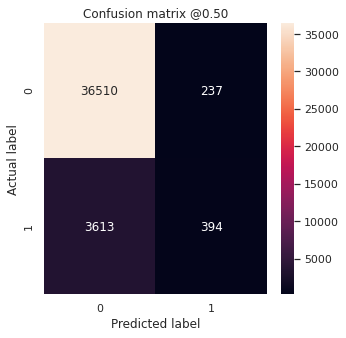

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Plot the ROC

Now plot the ROC. This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

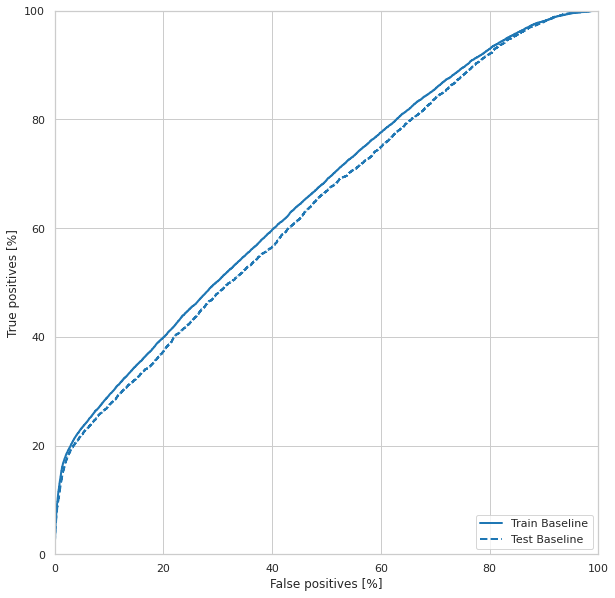

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Plot the AUPRC

Now plot the AUPRC. Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

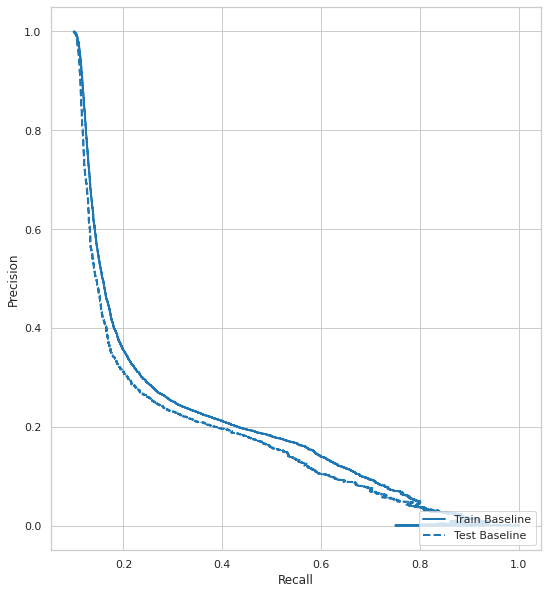

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

##We see that Precision, Recall and Accuracy have no noticeable results